In [12]:
from scipy import signal
import os
import pickle
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import torchaudio
import torch
from nnAudio import features
import torchaudio.transforms as T

[-0.05001831 -0.04949951 -0.04928589 ... -0.0017395  -0.00210571
 -0.00228882]


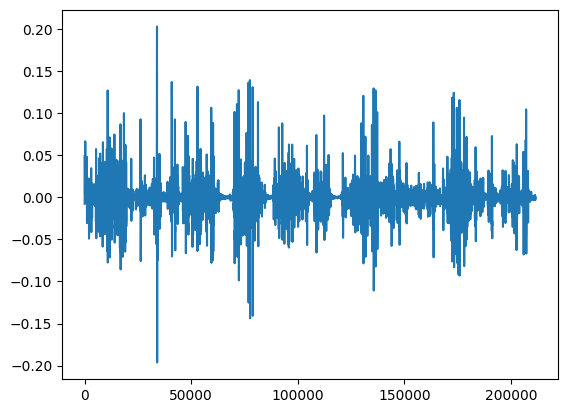

In [2]:
data, fs = librosa.load('7-class_Dataset/G1AluminumMesh/G1RhombAluminumMesh_Sound_Movement_train9.wav', sr=44100)
print(data)
b, a = signal.butter(3, [20 / fs, 1000 / fs], 'bandpass')
data = signal.filtfilt(b, a, data)
plt.plot(data)
DMatrix = librosa.stft(data, n_fft=2048, hop_length=int(2048 * 0.1), window='hann')
dbMatrix = librosa.amplitude_to_db(np.abs(DMatrix), ref=np.max)

In [3]:
sd.play(data, 44100)

In [8]:
from threading import Thread
import numpy as np
import sounddevice as sd
import time

class Test(Thread):
    def __init__(self):
        Thread.__init__(self)
        #-- Configuration of the Tone to be played
        self.fs = 44100       # sampling rate, in Hz, 44100 or 48000
        duration = 1.05  # in seconds, may be float
        f = 200.0        # sine frequency, Hz, may be float
        data, fs = librosa.load('Texture_Dataset/G1AluminumMesh/G1RhombAluminumMesh_Sound_Movement_train9.wav', sr=44100)
        b, a = signal.butter(3, [20 / fs, 1000 / fs], 'bandpass')
        self.data1 = signal.filtfilt(b, a, data)
        self.data2 = (np.sin(2*np.pi*np.arange(self.fs*duration)*f/self.fs)).astype(np.float32)

    def run(self):                       
        sd.default.channels = 1
        sd.default.device = 2
        print(sd.query_devices(sd.default.device)['name'])    
        sd.default.samplerate = self.fs                
        sd.play(self.data1)
        time.sleep(1)
        sd.play(self.data2)
        sd.wait()        

w = Test()        
w.start()
print('test')

MacBook Air麦克风test


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.10_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/var/folders/2q/c8qq60hx4r384y7n6vnldz7r0000gn/T/ipykernel_99451/2470770649.py", line 23, in run
  File "/opt/homebrew/lib/python3.10/site-packages/sounddevice.py", line 175, in play
    ctx.start_stream(OutputStream, samplerate, ctx.output_channels,
  File "/opt/homebrew/lib/python3.10/site-packages/sounddevice.py", line 2582, in start_stream
    self.stream = StreamClass(samplerate=samplerate,
  File "/opt/homebrew/lib/python3.10/site-packages/sounddevice.py", line 1494, in __init__
    _StreamBase.__init__(self, kind='output', wrap_callback='array',
  File "/opt/homebrew/lib/python3.10/site-packages/sounddevice.py", line 898, in __init__
    _check(_lib.Pa_OpenStream(self._ptr, iparameters, oparameters,
  File "/opt/homebrew/lib/python3.10/site-

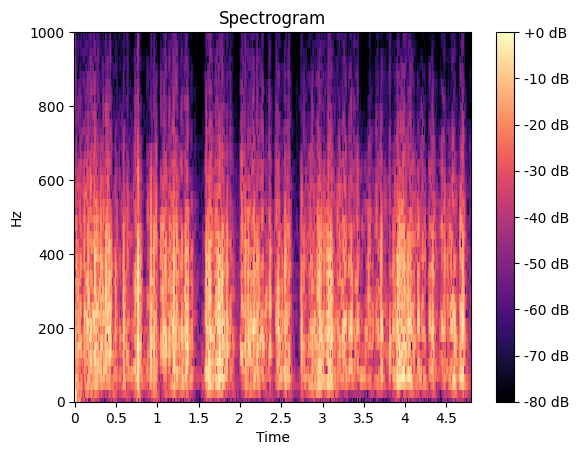

In [4]:
fig, ax = plt.subplots()
img = librosa.display.specshow(dbMatrix, sr=fs, n_fft=2048, hop_length=int(2048 * 0.1), y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Spectrogram')
plt.ylim(0, 1000)
fig.colorbar(img, ax=ax, format="%+2.0f dB")

(1025, 1038)


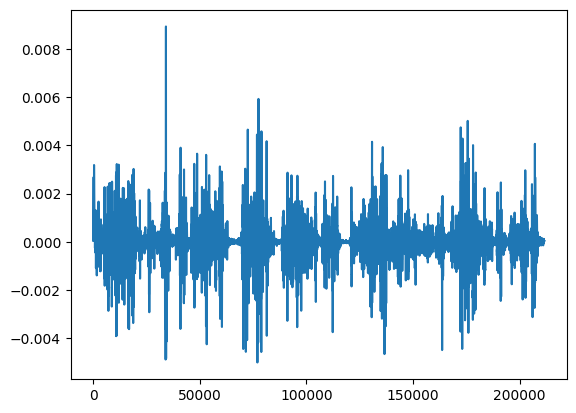

In [15]:
spec = dbMatrix[:48,:]

ex = np.full((1025-(spec.shape[0]), spec.shape[1]),-80)#もとの音声の周波数上限を切っているので配列の大きさを合わせるために-80dbで埋めている
spec = np.append(spec,ex,axis=0)
print(spec.shape)

spec = librosa.db_to_amplitude(dbMatrix)
re_wav = librosa.griffinlim(spec,n_iter=5,n_fft=2048, hop_length=int(2048 * 0.1), window='hann')
plt.plot(re_wav)

# from sklearn.metrics import mean_absolute_error
# print(mean_absolute_error(re_wav, data[:211548]))

(1025, 1038)


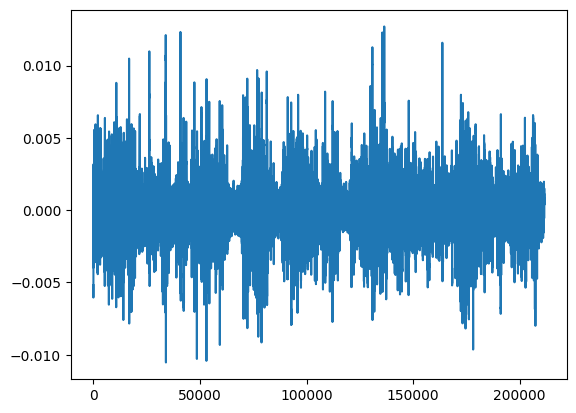

In [16]:
spec = dbMatrix[:48,:]

griffinlim = torchaudio.transforms.GriffinLim(n_fft=2048, n_iter=100, hop_length=int(2048 * 0.1)).to('cuda')

ex = np.full((1025-(spec.shape[0]), spec.shape[1]),-80)#もとの音声の周波数上限を切っているので配列の大きさを合わせるために-80dbで埋めている
spec = np.append(spec,ex,axis=0)
# spec = np.flip(spec)
print(spec.shape)

spec = librosa.db_to_amplitude(dbMatrix)
re_wav = griffinlim(torch.tensor(spec).to('cuda'))
plt.plot(re_wav.cpu().detach().numpy())

(1025, 1038)


c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\nnAudio\features\griffin_lim.py:110: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:979.)
  inverse = torch.istft(
c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:606: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:803.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


 ...]

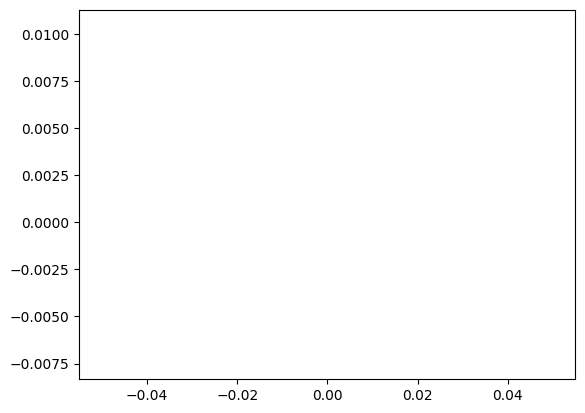

In [10]:
spec = dbMatrix[:48,:]

griffinlim = features.griffin_lim.Griffin_Lim(n_fft=2048, n_iter=100, hop_length=int(2048 * 0.1), window='hann', device='cuda')

ex = np.full((1025-(spec.shape[0]), spec.shape[1]),-80)#もとの音声の周波数上限を切っているので配列の大きさを合わせるために-80dbで埋めている
spec = np.append(spec,ex,axis=0)
# spec = np.flip(spec)
print(spec.shape)

spec = librosa.db_to_amplitude(spec)
re_wav = griffinlim(torch.tensor(spec).unsqueeze(dim=0).to('cuda'))
plt.plot(re_wav.cpu().detach().numpy())

In [8]:
sd.play(re_wav*22, 44100)

(48, 1038)


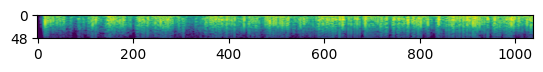

In [13]:
plt.imshow(dbMatrix[:48,:])
plt.yticks([0, 48])
print(np.array(dbMatrix[:48,:]).shape)

In [2]:
def wav2spec(wav_path):
    data, fs = librosa.load(wav_path, sr=44100)
    b, a = signal.butter(3, [20 / fs, 1000 / fs], 'bandpass')
    data = signal.filtfilt(b, a, data)
    DMatrix = librosa.stft(data, n_fft=2048, hop_length=int(2048 * 0.1), window='hann')
    dbMatrix = librosa.amplitude_to_db(np.abs(DMatrix), ref=np.max)

    return dbMatrix[:48,:]

In [9]:
# 7-class for test
dataset_path = '7-class_Dataset'
autoencoder_data = {"spectrogram": [], "texture": [], "filename":[]}

for texture_dir in os.listdir(dataset_path):
    if texture_dir[0] != '.':
        for spectrogram in os.listdir(dataset_path + '/' + texture_dir):
            spec = wav2spec(dataset_path + '/' + texture_dir + '/' + spectrogram)
            samples = np.lib.stride_tricks.sliding_window_view(spec,(48,320))
            samples = samples.squeeze()
            samples = samples[::5,]
            sample_n = samples.shape[0]
            autoencoder_data['spectrogram'].extend(samples)
            autoencoder_data['texture'].extend([texture_dir[:2]] * sample_n)
            autoencoder_data['filename'].extend([spectrogram] * sample_n)

autoencoder_data['spectrogram'] = np.array(autoencoder_data['spectrogram'])
file = open('trainset_7-class.pickle', 'wb')
pickle.dump(autoencoder_data, file)
file.close()


In [3]:
# 14-class for train
dataset_path = '14-class_Dataset'
autoencoder_data = {"spectrogram": [], "texture": [], "filename":[]}

for texture_dir in os.listdir(dataset_path):
    if texture_dir[0] != '.':
        for spectrogram in os.listdir(dataset_path + '/' + texture_dir):
            if spectrogram[0] != '.':
                spec = wav2spec(dataset_path + '/' + texture_dir + '/' + spectrogram)
                samples = np.lib.stride_tricks.sliding_window_view(spec,(48,320))
                samples = samples.squeeze()
                samples = samples[::5,]
                sample_n = samples.shape[0]
                autoencoder_data['spectrogram'].extend(samples)
                autoencoder_data['texture'].extend([texture_dir] * sample_n)
                autoencoder_data['filename'].extend([spectrogram] * sample_n)

autoencoder_data['spectrogram'] = np.array(autoencoder_data['spectrogram'])
file = open('trainset_14-class.pickle', 'wb')
pickle.dump(autoencoder_data, file)
file.close()

In [36]:
# whole dataset
dataset_path = 'LMT_108_SurfaceMaterials_Database/SoundScans/Movement/Training'
autoencoder_data = {"spectrogram": [], "texture": [], "filename":[]}

num_record = len(os.listdir(dataset_path))
print(num_record)
n = 0

for sound in os.listdir(dataset_path):
    spec = wav2spec(dataset_path + '/' + sound)
    samples = np.lib.stride_tricks.sliding_window_view(spec,(48,320))
    samples = samples.squeeze()
    samples = samples[::20,]
    sample_n = samples.shape[0]
    autoencoder_data['spectrogram'].extend(samples)
    texture_name = sound.split('_')
    texture_name = texture_name[0]
    n += 1
    print(str(n) + '/' + str(num_record) + ', ' + texture_name)
    autoencoder_data['texture'].extend([texture_name] * sample_n)
    autoencoder_data['filename'].extend([sound] * sample_n)

autoencoder_data['spectrogram'] = np.array(autoencoder_data['spectrogram'])
file = open('trainset_LMT_large.pickle', 'wb')
pickle.dump(autoencoder_data, file)
file.close()


1080
1/1080, G8Paper
2/1080, G7CoarseFoam
3/1080, G4WoodTypeSilverOak
4/1080, G2CrushedRock
5/1080, G4Larch
6/1080, G4CoreBeech
7/1080, G8GlitterPaperVersion1
8/1080, G3CeramicTile
9/1080, G7StyrofoamVersion1
10/1080, G7EpdmFoam
11/1080, G1FineAluminumMesh
12/1080, G9RedVelvet
13/1080, G8Cardboard
14/1080, G6IsolatingFoilVersion3
15/1080, G9Leather
16/1080, G5SolidRubberPlateVersion2
17/1080, G9TextileVersion1
18/1080, G7EpdmFoam
19/1080, G6Steelwool
20/1080, G9BlueSatin
21/1080, G6IsolatingFoilVersion2
22/1080, G5RubberPlateVersion2
23/1080, G7CoarseFoam
24/1080, G3EpoxyPlate
25/1080, G4LaminatedWood
26/1080, G6Carpet
27/1080, G8WallpaperVersion2
28/1080, G8WallpaperVersion2
29/1080, G6Carpet
30/1080, G8PlayingCardPaper
31/1080, G3EpoxyPlate
32/1080, G7CoarseFoam
33/1080, G9FloorClothVersion2
34/1080, G9BlueSatin
35/1080, G5RubberPlateVersion2
36/1080, G6IsolatingFoilVersion2
37/1080, G6IsolatingFoilVersion2
38/1080, G9TextileVersion1
39/1080, G7EpdmFoam
40/1080, G5SolidRubberPlateVer

In [39]:
with open('trainset_7-class.pickle', 'rb') as file:
    autoencoder_data = pickle.load(file)

In [40]:
print(len(autoencoder_data['texture']))

14400
